In [3]:
import os
import sys
import random
from datetime import datetime


sys.path.append('../src')

from design_gene_blocks import DesignEblocks
from design_IVA_primers import DesignPrimers
from snapgene_output import SnapGeneOutput
from utils import natural_amino_acids

# !pip3 install openpyxl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# TODO TRY RUNNING TESTS FROM COMMAND LINE AS WELL AND SEE IF THIS WORKS

In [5]:
# TODO Add image of the vector

# https://www.biotite-python.org/examples/gallery/sequence/plasmid_map_custom.html

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

In [6]:
# File locations for input and output

vector = 'files/snapgene_vector.dna' # TODO Change name and change vector (see snapgene computer which one to take)
msmeg_dnae1 = 'files/A0QX55.fasta'  # M. smegmatis DnaE1 gene
gene_name = "Msmeg_DnaE1"
output_location = 'output/'  # Location to store the files created in this notebook
codon_usage = 'Mycobacterium Smegmatis' # We want to use the codon usage of this organism
codon_usage_fp = r"C:\Users\Rosan\Documents\git\my_repositories\design_gene_blocks\src\data\codon_usage" # Location of the codon usage files
optimize = 'cost'

First we open the nucleotide sequence of Msmeg DnaE1 and translate this to the protein sequence. Here, the start and stop codon are not translated 

In [7]:
# Load the nucleotide sequence

msmeg_dnae1_dna = DesignEblocks.read_single_seq(msmeg_dnae1)
print("Nucleotide sequence: ", type(msmeg_dnae1_dna), msmeg_dnae1_dna)

# Translate nucleotide to protein sequence

msmeg_dnae1_protein = msmeg_dnae1_dna.translate()
print("Protein sequence: ", msmeg_dnae1_protein)

# Create a list of all DnaE1 residues

msmeg_dnae1_residues = [i + str(j) for i, j in zip(msmeg_dnae1_protein, range(1, len(msmeg_dnae1_protein) + 1))]
print("Residues: ", msmeg_dnae1_residues)

Nucleotide sequence:  <class 'Bio.Seq.Seq'> atgagcggttcatctgcggggtcctccttcgtgcacctgcacaaccacaccgagtattcgatgctggacggtgccgcgaagatcacgcccatgctcgccgaggtggagcggctggggatgcccgcggtggggatgaccgaccacggaaacatgttcggtgccagcgagttctacaactccgcgaccaaggccgggatcaagccgatcatcggcgtggaggcatacatcgcgccgggctcgcggttcgacacccggcgcatcctgtggggtgaccccagccaaaaggccgacgacgtctccggcagcggctcctacacgcacctgacgatgatggccgagaacgccaccggtctgcgcaacctgttcaagctgtcctcgcatgcttccttcgagggccagctgagcaagtggtcgcgcatggacgccgagctcatcgccgaacacgccgagggcatcatcatcaccaccggatgcccgtcgggggaggtgcagacccgcctgcggctcggccaggatcgggaggcgctcgaagccgcggcgaagtggcgggagatcgtcggaccggacaactacttccttgagctgatggaccacgggctgaccatcgaacgccgggtccgtgacggtctgctcgagatcggacgcgcgctcaacattccgcctcttgccaccaatgactgccactacgtgacccgcgacgccgcccacaaccatgaggctttgttgtgtgtgcagaccggcaagaccctctcggatccgaatcgcttcaagttcgacggtgacggctactacctgaagtcggccgccgagatgcgccagatctgggacgacgaagtgccgggcgcgtgtgactccaccttgttgatcgccgaacgggtgcagtcctacgccgacgtgtggacaccgcgcgaccggatgcccgtgtttccggtgcccgatgggcatgaccaggcgtc

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted

In [8]:
# Set of functions to randomly select mutations and insertions/deletions

def random_single_mutation(residues, aas, n):
    """
    Randomly select single mutations in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    """
    res = random.sample(residues, n)
    mut = random.choices(aas, k=n)
    mutants = [i + j for i, j in zip(res, mut)]
    return mutants

def random_multiple_mutation(residues, aas, n, max_distance_between_mutants=50, max_number_mutations=5):
    """
    Randomly select multiple mutations in a protein sequence that will be combined in one mutant.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    aas : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    max_distance_between_mutants : int
        Maximum distance (in residues) between the two mutations, default is set to 10
    """
    mutants = []  # List to store the mutants
    region_to_be_sampled = residues[(max_distance_between_mutants + 1):-max_distance_between_mutants]
    res1 = random.sample(region_to_be_sampled, n)
    var1 = random.choices(aas, k=n) 
    mut1 = [i + j for i, j in zip(res1, var1)]
    for i in mut1:
        temp_muts = []
        num_mutations = random.sample(range(1, max_number_mutations), 1)[0]
        pos_x = random.sample(range(1, max_distance_between_mutants), num_mutations)
        vars_x = random.choices(aas, k=num_mutations)  # Corrected typo here
        for j, k in zip(pos_x, vars_x):
            index = residues.index(i[0:-1])
            mut_x = residues[index + j] + k
            temp_muts.append(mut_x)
        mutants.append(i + '-' + '-'.join(temp_muts))
    return mutants


def random_insert(residues, aas, n, max_length_insertion=10):
    """
    Randomly generate insertions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of insertions to sample
    max_length_insertion : int 
        Maximum length of the insertion, default is set to 10
    """
    inserts = []  # List to store the inserts
    for i in range(n):
        len_insertion = random.sample(range(1, max_length_insertion), 1)[0]
        insertion = random.choices(aas, k=len_insertion)
        insertion = ''.join(insertion)
        residue = random.sample(residues, 1)[0]
        insert = residue + '-' + insertion
        inserts.append(insert)
    return inserts


def random_deletion(residues, n, max_length_deletion=10):
    """
    Randomly generate deletions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    n : int
        Number of deletions to sample
    max_length_deletion : int
        Maximum length of the deletion, default is set to 10
    """
    deletions = []
    for i in range(n):
        len_deletion = random.sample(range(1, max_length_deletion), 1)[0]
        res_b = random.sample(residues, 1)[0]
        res_e = residues[residues.index(res_b) + len_deletion]
        deletion = res_b + '-' + res_e
        deletions.append(deletion)
    return deletions

In [31]:
# Do not make the mutations at the very beginning and end of the protein sequence, because this will result in difficulties with the primers
usable_residues = msmeg_dnae1_residues[20:-20]

# List containing all natural amino acids and options for our mutations
amino_acids = natural_amino_acids()

# Randomly select single mutations
number_single = 50
selected_single_mutants = random_single_mutation(usable_residues, amino_acids, number_single)
print(f"Generated {number_single} single mutations: ", selected_single_mutants)

# Randomly select double mutations
number_double = 50
selected_double_mutants = random_multiple_mutation(usable_residues, amino_acids, number_double)
print(f"Generated {number_double} paired mutations: ", selected_double_mutants)

# Randomly select insertions
number_insertions = 10
selected_insertions = random_insert(usable_residues, amino_acids, number_insertions)
print(f"Generated {number_insertions} insertions: ", selected_insertions)

# Randomly select deletions
number_deletions = 10
selected_deletions = random_deletion(usable_residues, number_deletions)
print(f"Generated {number_deletions} deletions: ", selected_deletions)

total_number_mutations = number_single + number_double + number_insertions + number_deletions
print(f"Total number of mutations: {total_number_mutations}")

Generated 50 single mutations:  ['P1043D', 'T84K', 'S373R', 'S60K', 'D587V', 'D98F', 'L389K', 'K823F', 'H48V', 'A484C', 'A851A', 'D890C', 'E1050L', 'D252V', 'R605D', 'G39N', 'K723S', 'E982C', 'G336K', 'R832C', 'E706E', 'G790G', 'R205T', 'P30R', 'Q94V', 'V794Q', 'A476Q', 'D830F', 'R1162R', 'H1000L', 'N880T', 'D304F', 'A178L', 'A1128K', 'I494K', 'D91G', 'P414V', 'Y679C', 'A491L', 'I909F', 'L118Y', 'K882C', 'P1117P', 'I28G', 'E808P', 'Y708Y', 'I1072W', 'L38G', 'G103G', 'R344G']
Generated 50 paired mutations:  ['R563G-D574R-L612H-D587H', 'R701D-K741V', 'A149I-T155Y-E184A-D197I-C158D', 'P841E-G862G-Q877T', 'M739C-A782A', 'A178S-R204P', 'W182S-I213A', 'M673R-L696Y', 'G161A-T165F', 'V1077D-P1117M-A1092I-D1089R-V1078P', 'S852E-T878R-D887N-I895V', 'D1089M-A1128C-P1137V-L1093I-K1130H', 'G958T-F964K', 'M271I-R292A-Q294Q-P280L', 'A142P-N190P-E174I-W182Y', 'G956H-T957D-K976S-L979V-P962E', 'A546S-L560G', 'I857G-F888N-G862V-C900Y-V867H', 'K463I-T482N', 'A789D-Y809C-Y827N', 'G281N-L288F-G328Q-D298A', 

In [32]:
# Formatting the mutations in a format that can be read by the DesignEblocks class, see documentation for more information about this

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d")
mutationsfile = f'output/mutations_random_{gene_name}_N{total_number_mutations}_{dt_string}.txt'

with open(mutationsfile, 'w') as f:
    for i in selected_single_mutants:
        f.write(i + '\n')
    for i in selected_double_mutants:
        f.write('Combined ' + i + '\n')
    for i in selected_insertions:
        f.write('Insert ' + i + '\n')
    for i in selected_deletions:
        f.write('Deletion ' + i + '\n')

Now that we have selected the mutations that we want to create, we can start the design of the eBlocks. <br>
First, we create an instance of the DesignEblocks class and provide the information. Next we will start the design of the eBlocks. <br>
<br>

TODO: Describe the steps that are carried out in this class

In [48]:
# Create instance of DesignEblocks to design the eBlocks per mutation

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        gene_name=gene_name,
                        mutations_fp=mutationsfile,
                        optimize='amount', # Optimize for the cost of the eBlocks (default) 'cost', or for the number of eBlocks 'amount'
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

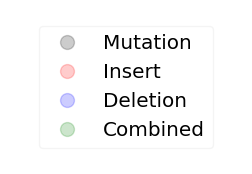

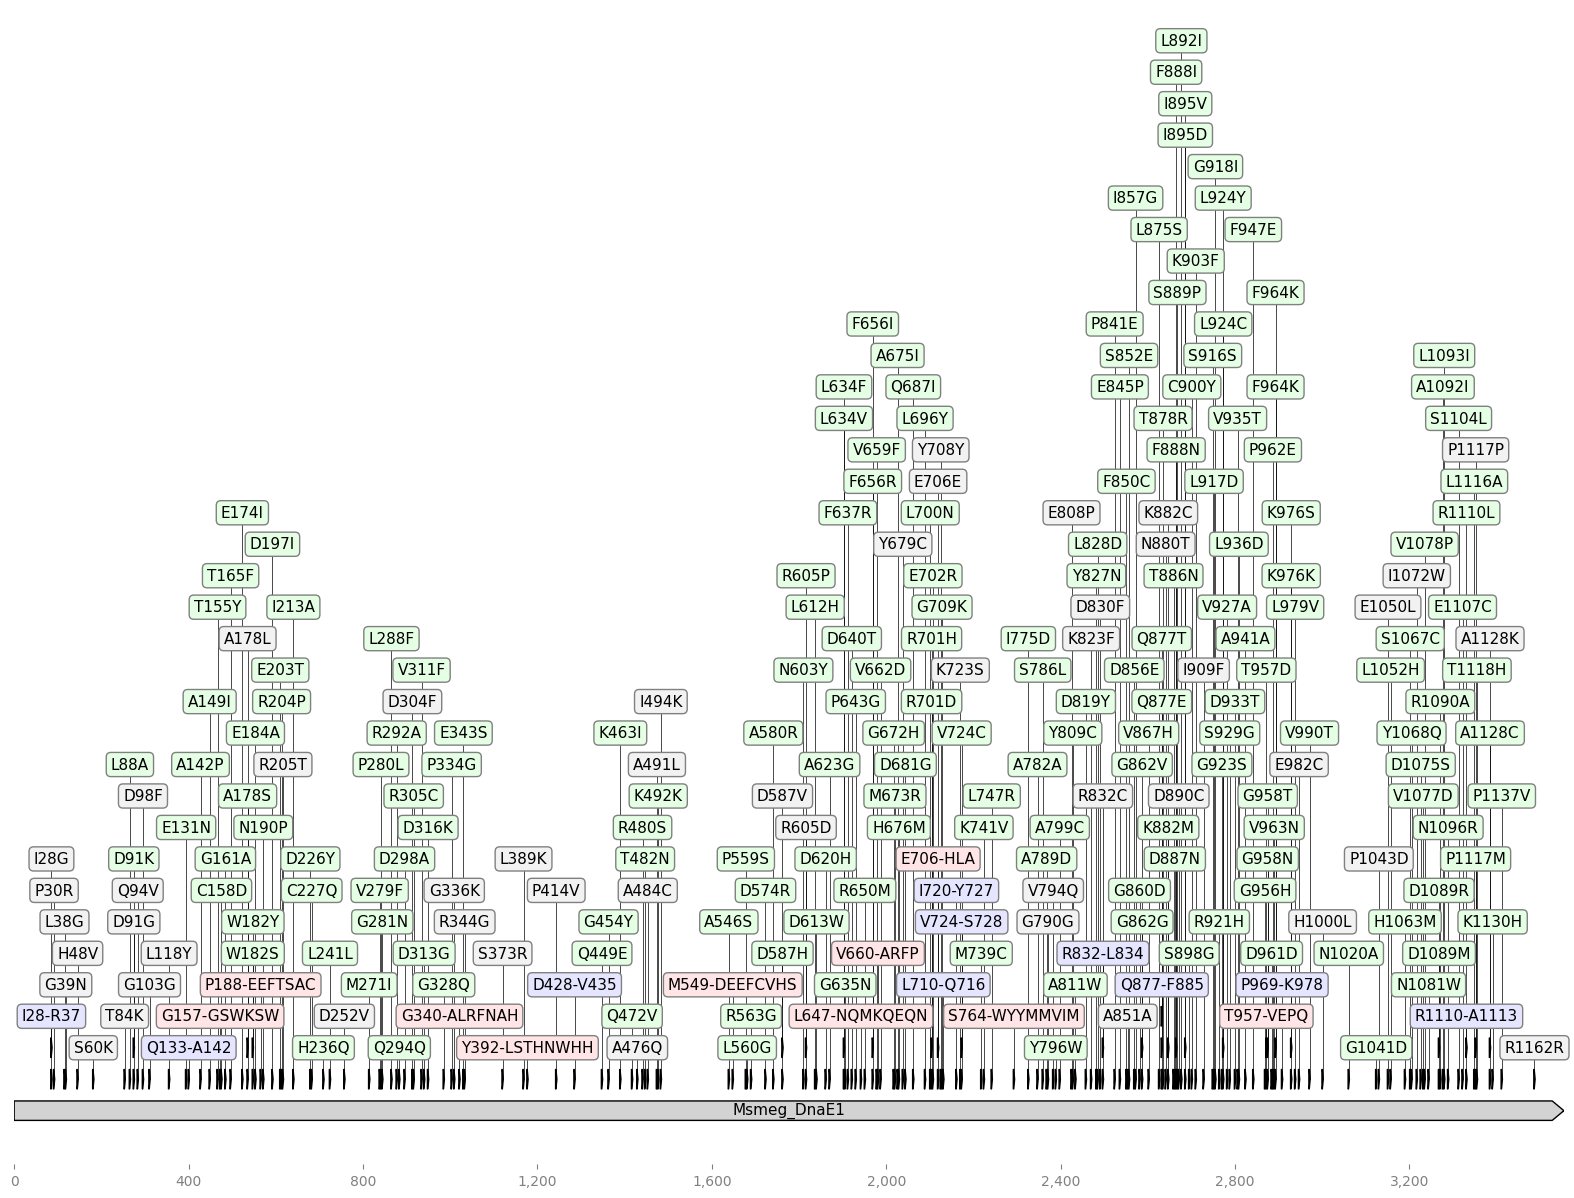

In [49]:
# First, lets take a look at the mutations that we have selected

# Plot and save the legend

legend = eBlocks_instance.plot_legend(show=True)
legend.savefig(output_location + 'legend.png', dpi=100)

record = eBlocks_instance.plot_eblocks_mutations(idx_dna_tups=None, eblocks=False, mutations=True, genename=eBlocks_instance.gene_name)
ax, _ = record.plot(figure_width=20)

# Save the eBlocks plot
ax.figure.savefig( f'{output_location}/mutations_{gene_name}_N{total_number_mutations}_{dt_string}.png', dpi=300)

In [57]:
eBlocks_instance.run(show=False)  # Show plots

Optimizing based on amount of eBlocks ...
Fewest blocks: 3 with cluster cluster N=9
expected cost, counting 0.05 cent per bp: 17301.4 euros
120


ValueError: too many values to unpack (expected 2)

In the above plot we can view the mutations and how they are divided over the gene. Now we let the program design the eBlock regions in such a way that as many mutations as possible are put on the same eBlock.

Optimizing based on amount of eBlocks ...
Fewest blocks: 3 with cluster {1: [3129, 2469, 2553, 2670, 3150, 2946, 2496, 2370, 2382, 2490, 3486, 3000, 2640, 3384, 2727, 2646, 3351, 2424, 3216, 2580.0, 3271.8, 2634.0, 3346.2, 2883.0, 2898.0, 2624.4, 2425.0, 2604.0, 3135.0, 3314.25, 2907.0, 2647.5, 2407.5, 3245.0, 2447.4, 2777.4, 2688.0, 2814.6, 2787.75, 2728.8, 3273.0, 2871, 2919.0, 2641.5, 3333.0, 2497.5, 2523, 2586, 2631, 3231, 3351, 3276, 3267, 3234, 2556, 2634, 2661, 2685, 3267, 3384, 3411, 3279, 3390, 2874, 2892, 2868, 2871, 2928, 2937, 2886, 2571, 2664, 2586, 2700, 2601, 2367, 2427, 2481, 2550, 2646, 2580, 2676, 2568, 3060, 3123, 3156, 3201, 3225, 3330, 3348, 3354, 2841, 2970, 2928, 2889, 2631, 2664, 2358, 2457, 3204, 3288, 3243, 2388, 2484, 2535, 2397, 2433, 2694, 2763, 2799, 2808, 2823, 2625, 2667, 2772, 2754, 2892, 2772, 2874, 2781, 2748, 2883, 2751, 2769, 2658, 2685, 2787, 2805, 2709, 3189, 3312, 3321, 3270, 2907, 2910, 2913, 2916, 2919, 2922, 2925, 2928, 2931, 2631, 2634, 2637,

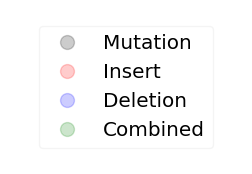

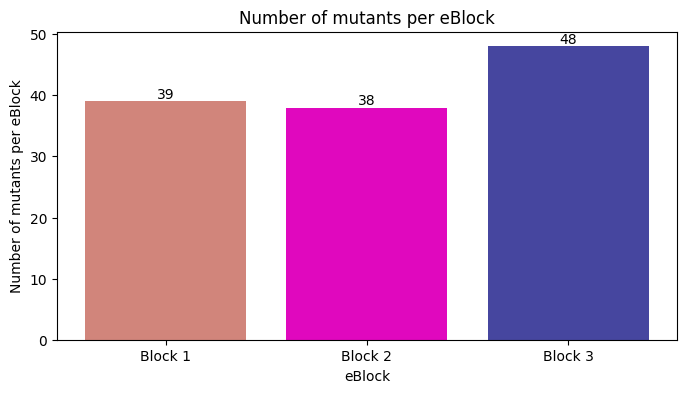

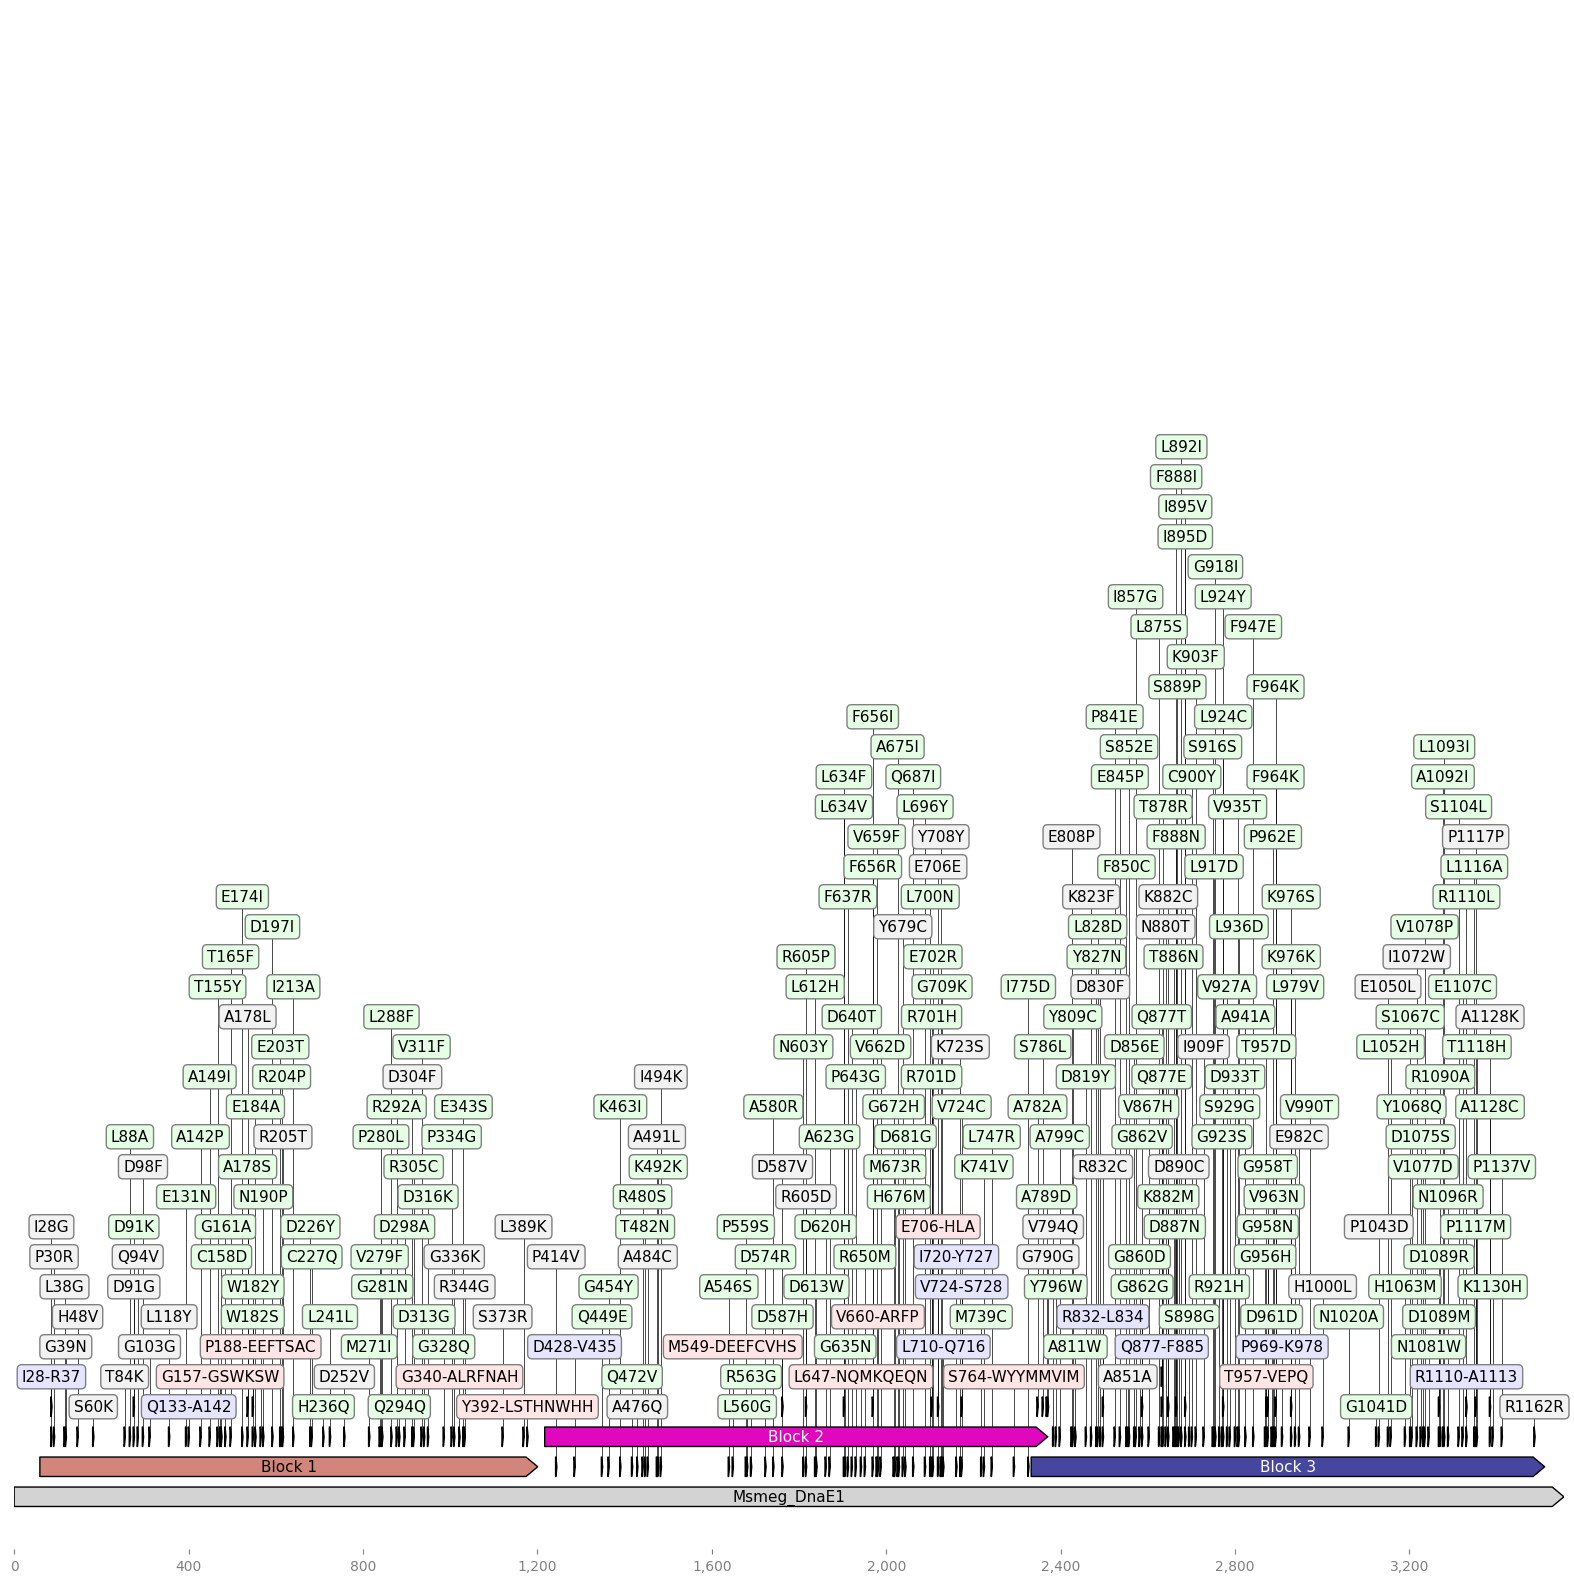

In [63]:
# Run the design of the eBlocks

# TODO Find a way to not show the plot of the eBlocks, but still save it
# TODO store eblocks data and plot based on that data
# ORIGINAL

eBlocks_instance.run(show=True)

In [1]:
# Now lets do the same but optimize the amount of eBlocks instead of the cost

optimize = 'amount'

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        gene_name=gene_name,
                        mutations_fp=mutationsfile,
                        optimize=optimize, # Optimize for the cost of the eBlocks (default) 'cost', or for the number of eBlocks 'amount'
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

eBlocks_instance.run()

NameError: name 'DesignEblocks' is not defined

In [ ]:
# TODO DESCRIBE THE DIFFERENT FILES THAT ARE GENERATED AND WHAT THEY CONTAIN

In this plot you can see .. how many mutants you can make with an eBlock

In [ ]:
# DECRIBE THE NEXT STEPS

In [ ]:
# Next; design IVA primers to open up destination plasmid

# TODO FOR THE PRIMER DESIGN TAKE A MAX PLASMID SIZE OF 10 KB, BECAUSE THIS IS THE MAX SIZE THAT CAN BE amplified simply using PCR. Othewise throw a warning

mut_gene_blocks_fp = os.path.join(output_location, "mut_gene_blocks.npy")
wt_gene_blocks_fp = os.path.join(output_location, "wt_gene_blocks.npy")

# Create class instance

design_primers = DesignPrimers(wt_gene_blocks_fp=wt_gene_blocks_fp, 
                               mut_gene_blocks_fp=mut_gene_blocks_fp, 
                               output_location=output_location,
                               input_gene_path=gene,
                               snapgene_file=vector)

# Design the primers

design_primers.run()

# Also write results to files that SnapGene can open
primers_fp = os.path.join(output_location, "IVA_primers.csv")
gene_blocks_mutation_info_fp = os.path.join(output_location, "gene_blocks.txt")

# If you have SnapGene installed, you can add the mutations as features in this file

snapgene_output = SnapGeneOutput(wt_gene_blocks_fp = wt_gene_blocks_fp,
                                 mut_gene_blocks_fp = mut_gene_blocks_fp,
                                 primers_fp = primers_fp,
                                 output_location = output_location,
                                 snapgene_file = vector,
                                 gene_blocks_info_fp = gene_blocks_mutation_info_fp)
snapgene_output.run()


In [ ]:
# TODO CLEANUP AND REMOVE UNNECCESSARY FILES